In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Fake News Classification Project
# Full code for preprocessing, training models, evaluation

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

fake = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MLProject/Fake.csv')
real = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MLProject/True.csv')

fake['label'] = 0
real['label'] = 1
df = pd.concat([fake, real]).sample(frac=1).reset_index(drop=True) # merging both datasets
df.rename(columns={'text': 'body'}, inplace=True)
print("Info :")
print(df.info()) #dataset info
print("Top 5 rows: ")
print(df.head()) #top rows



Info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   body     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
None
Top 5 rows: 
                                               title  \
0   The Pope Just Called Most American Employers ...   
1  Putin-linked think tank drew up plan to sway 2...   
2  U.S. investigators seek to turn Manafort in Ru...   
3  Democratic champion of 1986 tax reform says Tr...   
4  “NEVER-TRUMP” BUSTED! Former Jeb Bush Staffer ...   

                                                body       subject  \
0  Pope Francis is no fan of Walmart or of McDona...          News   
1  WASHINGTON (Reuters) - A Russian government th...  politicsNews   
2  WASHINGT

In [ ]:
print(df.isna().sum()) #No missing values found
df.dropna(subset=['title', 'body'], inplace=True) # drop NA Values
df.drop_duplicates(subset=['body'], inplace=True) # dropping duplicates if present from body and title
df.drop_duplicates(subset=['title'], inplace=True)

# CLEANING FUNCTIONS
for i in df.columns[:2]:
    df[i] = df[i].str.lower() #lowercase
    df[i] = df[i].str.replace(r'http\S+|www.\S+', '', regex=True) #replace URL and http
    df[i] = df[i].str.replace(r'[^a-z\s]', ' ', regex=True) # replace punctuations
    df[i] = df[i].str.replace(r'\s+', ' ', regex=True)   #remove whitespace

print(df.head())

title      0
body       0
subject    0
date       0
label      0
dtype: int64
                                               title  \
0   the pope just called most american employers ...   
1  putin linked think tank drew up plan to sway u...   
2  u s investigators seek to turn manafort in rus...   
3  democratic champion of tax reform says trump p...   
4   never trump busted former jeb bush staffer ad...   

                                                body       subject  \
0  pope francis is no fan of walmart or of mcdona...          News   
1  washington reuters a russian government think ...  politicsNews   
2  washington reuters u s investigators examining...  politicsNews   
3  washington reuters former u s senator bill bra...  politicsNews   
4  just another member of the swamp who s about t...      politics   

                date  label  
0       May 19, 2016      0  
1    April 19, 2017       1  
2     July 22, 2017       1  
3  October 25, 2017       1  
4        Dec 9


--- Text Length Statistics ---
          title_len      body_len
count  38270.000000  38270.000000
mean      12.466161    406.971806
std        3.906019    318.087862
min        0.000000      0.000000
25%       10.000000    219.000000
50%       12.000000    373.000000
75%       14.000000    516.000000
max       44.000000   8281.000000


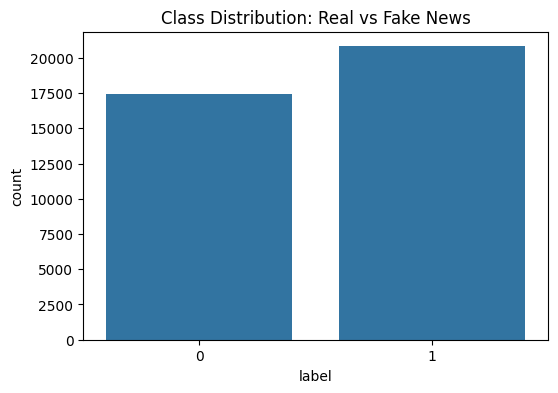

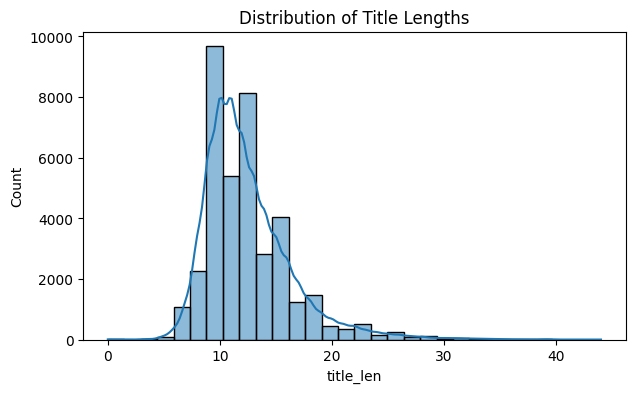

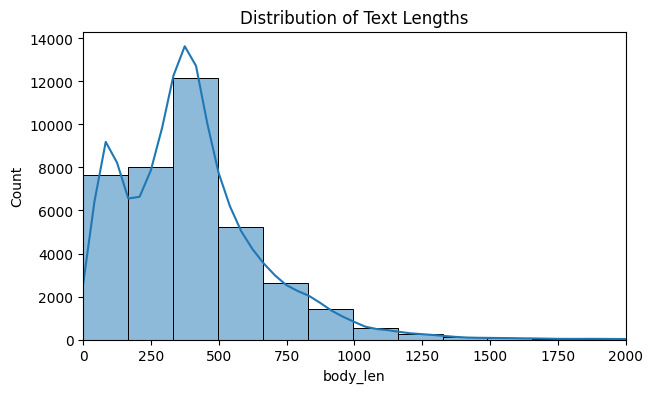

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# TEXT LENGTH FEATURES
df["title_len"] = df["title"].apply(lambda x: len(x.split()))
df["body_len"] = df["body"].apply(lambda x: len(x.split()))

print("\n--- Text Length Statistics ---")
print(df[["title_len", "body_len"]].describe())

plt.figure(figsize=(6,4))
sns.countplot(data=df, x="label")
plt.title("Class Distribution: Real vs Fake News")
plt.show()

# TITLE LENGTH DISTRIBUTION
plt.figure(figsize=(7,4))
sns.histplot(df["title_len"], bins=30, kde=True)
plt.title("Distribution of Title Lengths")
plt.show() #we can see that most title length are in the 8-15 range

# BODY LENGTH DISTRIBUTION
plt.figure(figsize=(7,4))
sns.histplot(df["body_len"], bins=50, kde=True)
plt.xlim(0,2000)
plt.title("Distribution of Text Lengths")
plt.show() #we can see that body of the article are in 0-1500 range

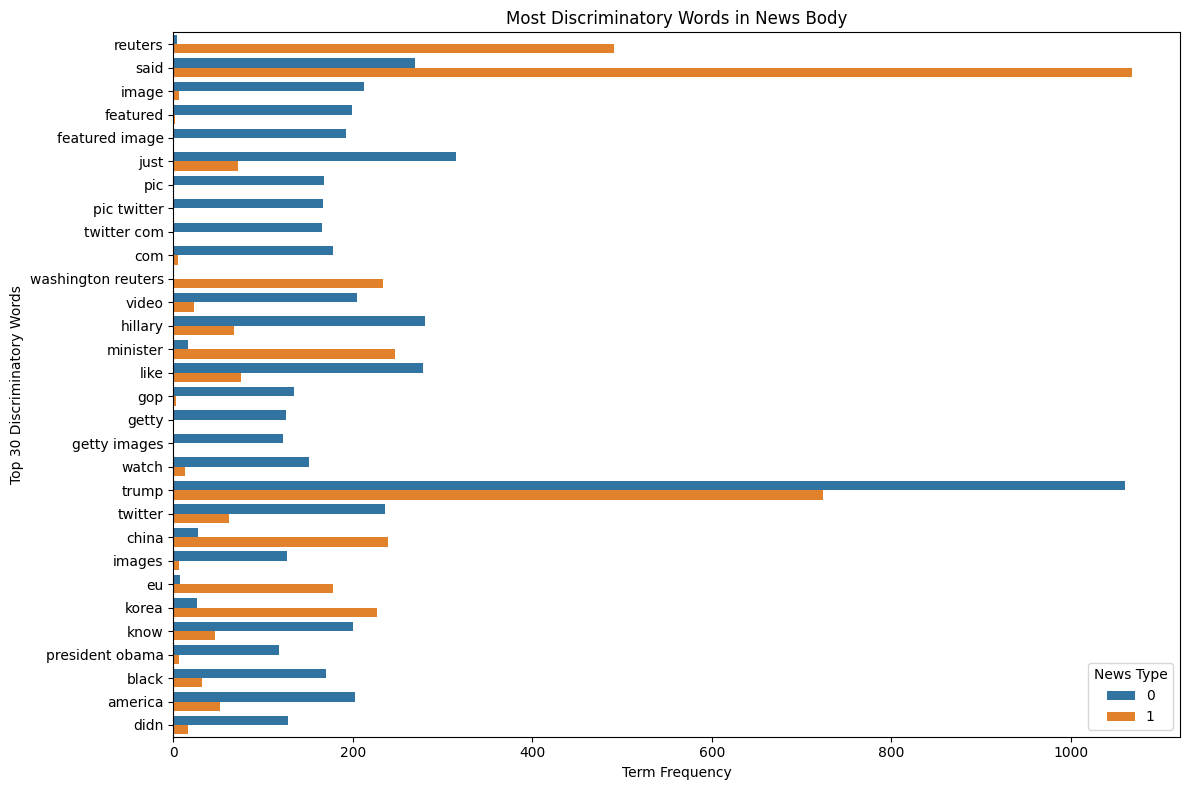

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np
tfidf = TfidfVectorizer(max_features=50000, stop_words='english', ngram_range=(1,2))
X = tfidf.fit_transform(df['body'])
y = df['label']


#Chi-squared test for top discriminatory words
chi2_scores, p_values = chi2(X, y)
feature_names = np.array(tfidf.get_feature_names_out())

# DataFrame with words, chi2 score
chi2_df = pd.DataFrame({
    'word': feature_names,
    'chi2': chi2_scores
})

# top 30 words by chi2 score
top_words = chi2_df.sort_values(by='chi2', ascending=False).head(30)['word'].values

# 3used this to reduce memory usage to use only top 30 words, it was giving memory error earlier
top_word_indices = [tfidf.vocabulary_[w] for w in top_words]
X_top_sparse = X[:, top_word_indices]

# Convert to DataFrame
X_top_df = pd.DataFrame.sparse.from_spmatrix(X_top_sparse, columns=top_words)
X_top_df['type'] = y.values

# Aggregate  by category
top_word_freq = X_top_df.groupby('type').sum().reset_index()
top_word_freq_melted = top_word_freq.melt(id_vars='type', var_name='word', value_name='frequency')

# Plot top discriminatory words
plt.figure(figsize=(12,8))
sns.barplot(data=top_word_freq_melted, x='frequency', y='word', hue='type')
plt.xlabel("Term Frequency")
plt.ylabel("Top 30 Discriminatory Words")
plt.title("Most Discriminatory Words in News Body")
plt.legend(title='News Type')
plt.tight_layout()
plt.show()

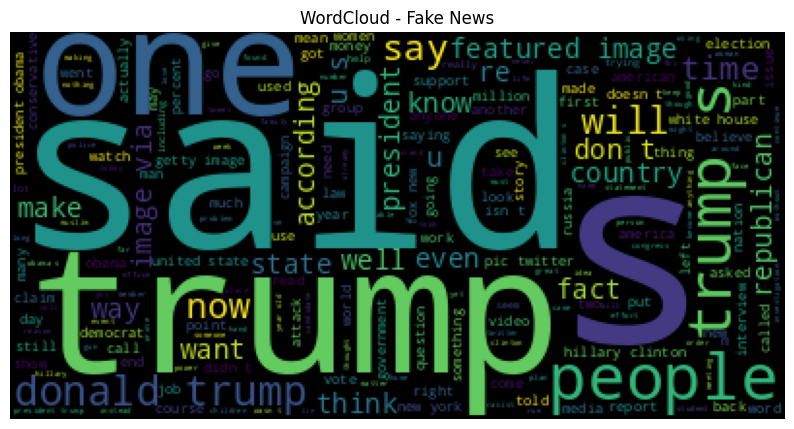

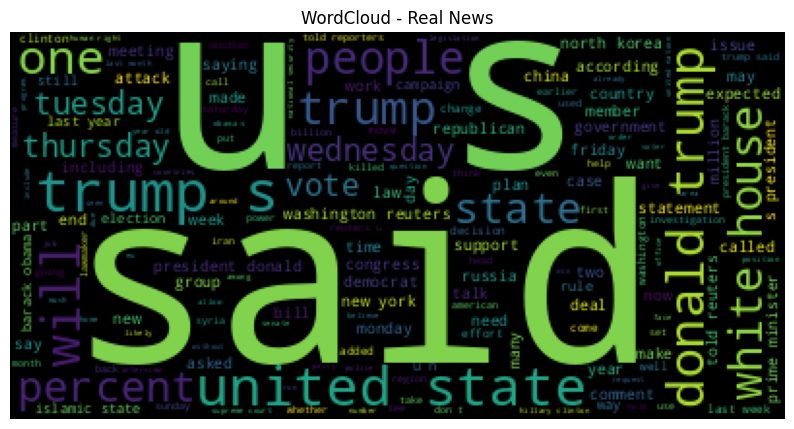

In [ ]:
# WORDCLOUDS
# -----------------------------
from wordcloud import WordCloud

fake_text = " ".join(df[df["label"]==0]["body"])
real_text = " ".join(df[df["label"]==1]["body"])

plt.figure(figsize=(10,6))
plt.imshow(WordCloud(max_words=500).generate(fake_text))
plt.title("WordCloud - Fake News")
plt.axis("off")
plt.show()

plt.figure(figsize=(10,6))
plt.imshow(WordCloud(max_words=500).generate(real_text))
plt.title("WordCloud - Real News")
plt.axis("off")
plt.show()

In [ ]:

#BASELINE MODEL (MAJORITY CLASS)

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
X = df['title']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Majority class classifier
majority_class = y_train.mode()[0]
y_pred_majority = np.full_like(y_test, fill_value=majority_class)

accuracy = accuracy_score(y_test, y_pred_majority)
print("\nBaseline Majority-Class Accuracy For Title:", accuracy)

X = df['body']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Majority class classifier for Body
majority_class = y_train.mode()[0]
y_pred_majority = np.full_like(y_test, fill_value=majority_class)

accuracy = accuracy_score(y_test, y_pred_majority)
print("\nBaseline Majority-Class Accuracy For Body:", accuracy)


Baseline Majority-Class Accuracy For Title: 0.5440292657434022

Baseline Majority-Class Accuracy For Body: 0.5440292657434022


In [ ]:
def logisticregression_tuning(X_train, X_test,X_test_raw, y_train, y_test, col):
    param_grid_lr = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["liblinear"]
    }

    grid_lr = GridSearchCV(LogisticRegression(max_iter=300), param_grid_lr, cv=5, n_jobs=-1)
    grid_lr.fit(X_train, y_train)

    print("\n==== Logistic Regression Grid Search ====")
    print("Best Params:", grid_lr.best_params_)
    print("Best CV Score:", grid_lr.best_score_)

# Evaluate tuned model
    lr_tuned_preds = grid_lr.predict(X_test)

    print("\n=== Tuned Logistic Regression Results ===")
    print(classification_report(y_test, lr_tuned_preds))
    cm = confusion_matrix(y_test, lr_tuned_preds)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    results.append({
        "Model": 'Logistic Regression',
        "Stage": "After Tuning",
        "Column":col,
        "Accuracy": accuracy_score(y_test, lr_tuned_preds),
        "F1-Score": f1_score(y_test, lr_tuned_preds)
    })
    # Create error analysis dataframe
    errors.append({
    "Model": 'Logistic Regression',
    "Column":col,
    "text":X_test_raw.values,
    "true_label": y_test.values,
    "predicted_label": lr_tuned_preds
    })
    return grid_lr

In [ ]:
def naivebayes_tuning(X_train, X_test,X_test_raw, y_train, y_test, col):

    param_grid_nb = {"alpha": [0.1, 0.5, 1.0]}

    grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5)
    grid_nb.fit(X_train, y_train)

    print("\n=== Naive Bayes Best Params ===")
    print(grid_nb.best_params_)
    print("Best CV Score:", grid_nb.best_score_)

    nb_preds = grid_nb.predict(X_test)
    print(classification_report(y_test, nb_preds))
    cm = confusion_matrix(y_test, nb_preds)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    results.append({
        "Model": 'Naive Bayes',
        "Stage": "After Tuning",
        "Column": col,
        "Accuracy": accuracy_score(y_test, nb_preds),
        "F1-Score": f1_score(y_test, nb_preds)
    })

    errors.append({
    "Model": 'Naive Bayes',
    "Column": col,
        "text":X_test_raw.values,
    "true_label": y_test.values,
    "predicted_label": nb_preds
    })
    return grid_nb

In [ ]:
def randomforest_tuning(X_train, X_test,X_test_raw, y_train, y_test, col):
    param_grid_rf = {
    "n_estimators": [50, 100],
    "max_depth": [50, 100, None]
    }

    grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=3, n_jobs=-1)
    grid_rf.fit(X_train, y_train)

    print("\n=== Random Forest Best Params ===")
    print(grid_rf.best_params_)
    print("Best CV Score:", grid_rf.best_score_)

    rf_preds = grid_rf.predict(X_test)
    print(classification_report(y_test, rf_preds))
    cm = confusion_matrix(y_test, rf_preds)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    results.append({
        "Model": 'Random Forest',
        "Stage": "After Tuning",
        "Column": col,
        "Accuracy": accuracy_score(y_test, rf_preds),
        "F1-Score": f1_score(y_test, rf_preds)
    })
    errors.append({
    "Model": 'Random Forest',
    "Column": col,
        "text":X_test_raw.values,
    "true_label": y_test.values,
    "predicted_label": rf_preds
    })
    return grid_rf


==== Logistic Regression Grid Search ====
Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV Score: 0.9440489505737647

=== Tuned Logistic Regression Results ===
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      3490
           1       0.94      0.96      0.95      4164

    accuracy                           0.94      7654
   macro avg       0.94      0.94      0.94      7654
weighted avg       0.94      0.94      0.94      7654



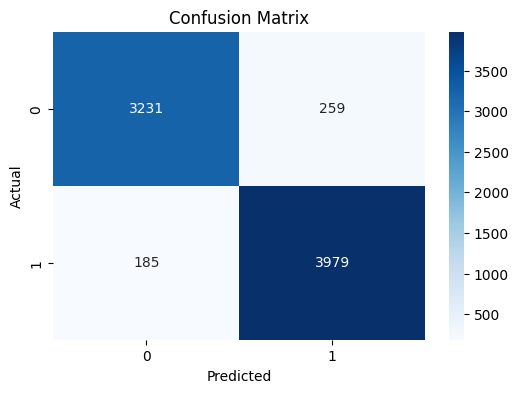


=== Naive Bayes Best Params ===
{'alpha': 0.5}
Best CV Score: 0.9396395127834968
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      3490
           1       0.94      0.94      0.94      4164

    accuracy                           0.94      7654
   macro avg       0.94      0.94      0.94      7654
weighted avg       0.94      0.94      0.94      7654



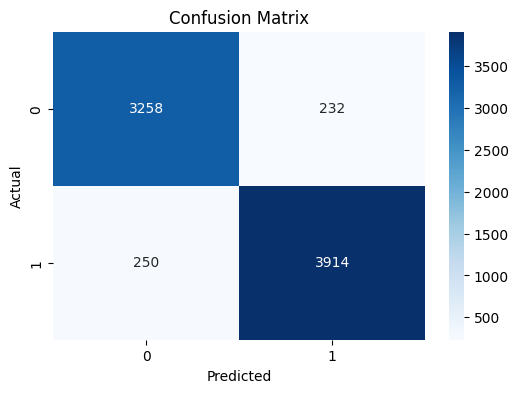


=== Random Forest Best Params ===
{'max_depth': None, 'n_estimators': 100}
Best CV Score: 0.9216096157198619
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      3490
           1       0.91      0.95      0.93      4164

    accuracy                           0.92      7654
   macro avg       0.92      0.92      0.92      7654
weighted avg       0.92      0.92      0.92      7654



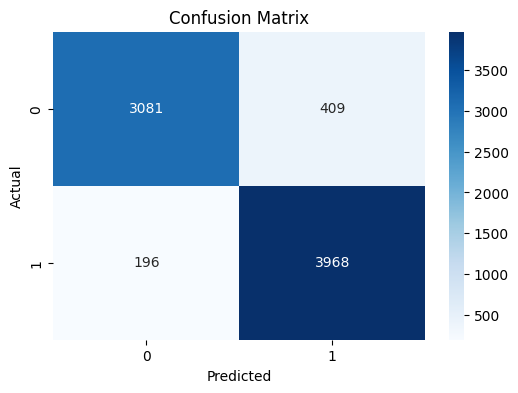

In [ ]:
#Data Preprocessing
tfidf = TfidfVectorizer(max_features=50000, stop_words='english',ngram_range=(1,2)) #converting into numeric feature
results = []
errors = []

#Approach 1. Fake news detection from title of the news article:
X = df['title']
y = df['label']


X_train, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #splitting data into 80-20
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test_raw)

#hyperparameter tuning every model
logisticregression_tuning(X_train,X_test, X_test_raw, y_train, y_test,'title')
naivebayes_tuning(X_train,X_test, X_test_raw, y_train, y_test,'title')
randomforest_tuning(X_train,X_test, X_test_raw, y_train, y_test,'title')


==== Logistic Regression Grid Search ====
Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV Score: 0.9899071910656279

=== Tuned Logistic Regression Results ===
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3490
           1       0.99      1.00      0.99      4164

    accuracy                           0.99      7654
   macro avg       0.99      0.99      0.99      7654
weighted avg       0.99      0.99      0.99      7654



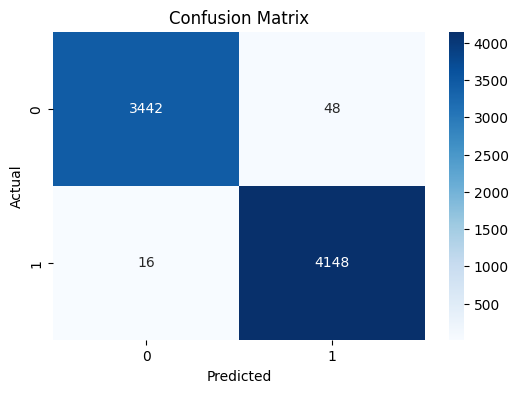


=== Naive Bayes Best Params ===
{'alpha': 0.1}
Best CV Score: 0.9519532684688468
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      3490
           1       0.96      0.96      0.96      4164

    accuracy                           0.96      7654
   macro avg       0.96      0.96      0.96      7654
weighted avg       0.96      0.96      0.96      7654



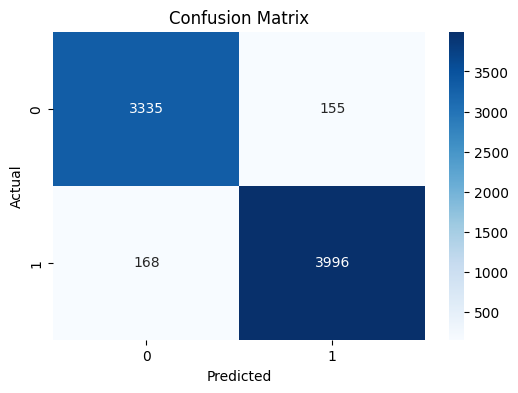


=== Random Forest Best Params ===
{'max_depth': None, 'n_estimators': 100}
Best CV Score: 0.9904624509720051
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3490
           1       0.99      1.00      1.00      4164

    accuracy                           0.99      7654
   macro avg       1.00      0.99      0.99      7654
weighted avg       0.99      0.99      0.99      7654



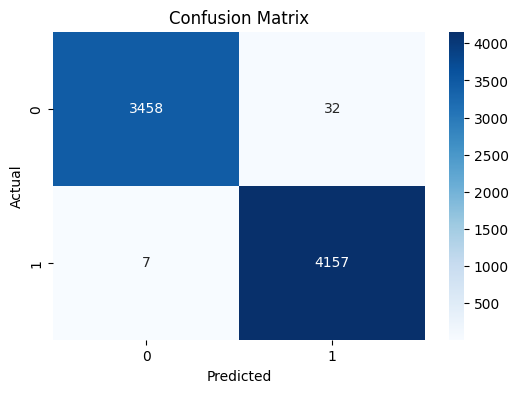

In [ ]:

#Approach 2. Fake news detection from body of the news article with hypertuning:
from sklearn.metrics import accuracy_score, f1_score, classification_report
X = df['body']
y = df['label']

X_train, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #splitting data into 80-20
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test_raw)
logisticregression_tuning(X_train, X_test,X_test_raw, y_train, y_test,'body')
naivebayes_tuning(X_train, X_test, X_test_raw,y_train, y_test,'body')
randomforest_tuning(X_train, X_test,X_test_raw, y_train, y_test,'body')




==== Logistic Regression Grid Search ====
Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV Score: 0.9916057368683976

=== Tuned Logistic Regression Results ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3490
           1       0.99      0.99      0.99      4164

    accuracy                           0.99      7654
   macro avg       0.99      0.99      0.99      7654
weighted avg       0.99      0.99      0.99      7654



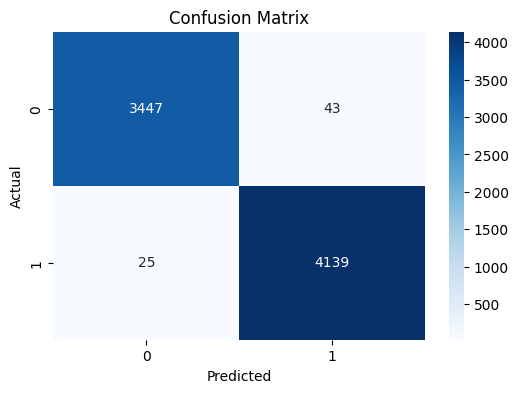


=== Naive Bayes Best Params ===
{'alpha': 0.1}
Best CV Score: 0.9558726863504559
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      3490
           1       0.96      0.95      0.96      4164

    accuracy                           0.96      7654
   macro avg       0.96      0.96      0.96      7654
weighted avg       0.96      0.96      0.96      7654



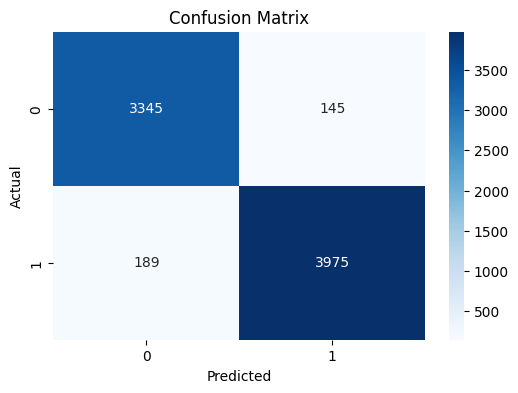


=== Random Forest Best Params ===
{'max_depth': 100, 'n_estimators': 100}
Best CV Score: 0.9927162385289302
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3490
           1       0.99      1.00      0.99      4164

    accuracy                           0.99      7654
   macro avg       0.99      0.99      0.99      7654
weighted avg       0.99      0.99      0.99      7654



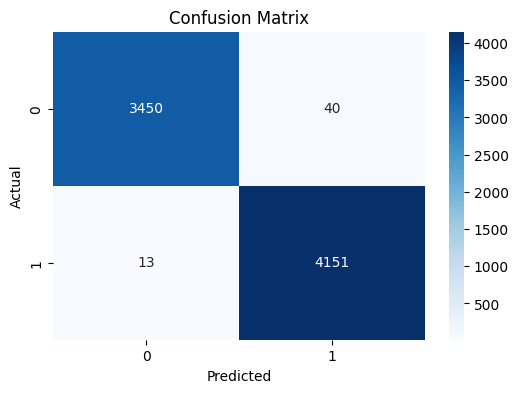

In [ ]:

#Approach 3. Fake news detection from body OR TITLE of the news article:
from sklearn.metrics import accuracy_score, f1_score, classification_report
X = (df['title'].astype(str) + " " + df['body'].astype(str))
y = df['label']

X_train, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #splitting data into 80-20
#refit TF-IDF
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test_raw)

global_grid_lr = logisticregression_tuning(X_train, X_test,X_test_raw, y_train, y_test,'title + body')
global_grid_nb = naivebayes_tuning(X_train, X_test, X_test_raw, y_train, y_test,'title + body')
global_grid_rf = randomforest_tuning(X_train, X_test,X_test_raw, y_train, y_test,'title + body')

df_results = pd.DataFrame(results)
df_error = pd.DataFrame(errors)


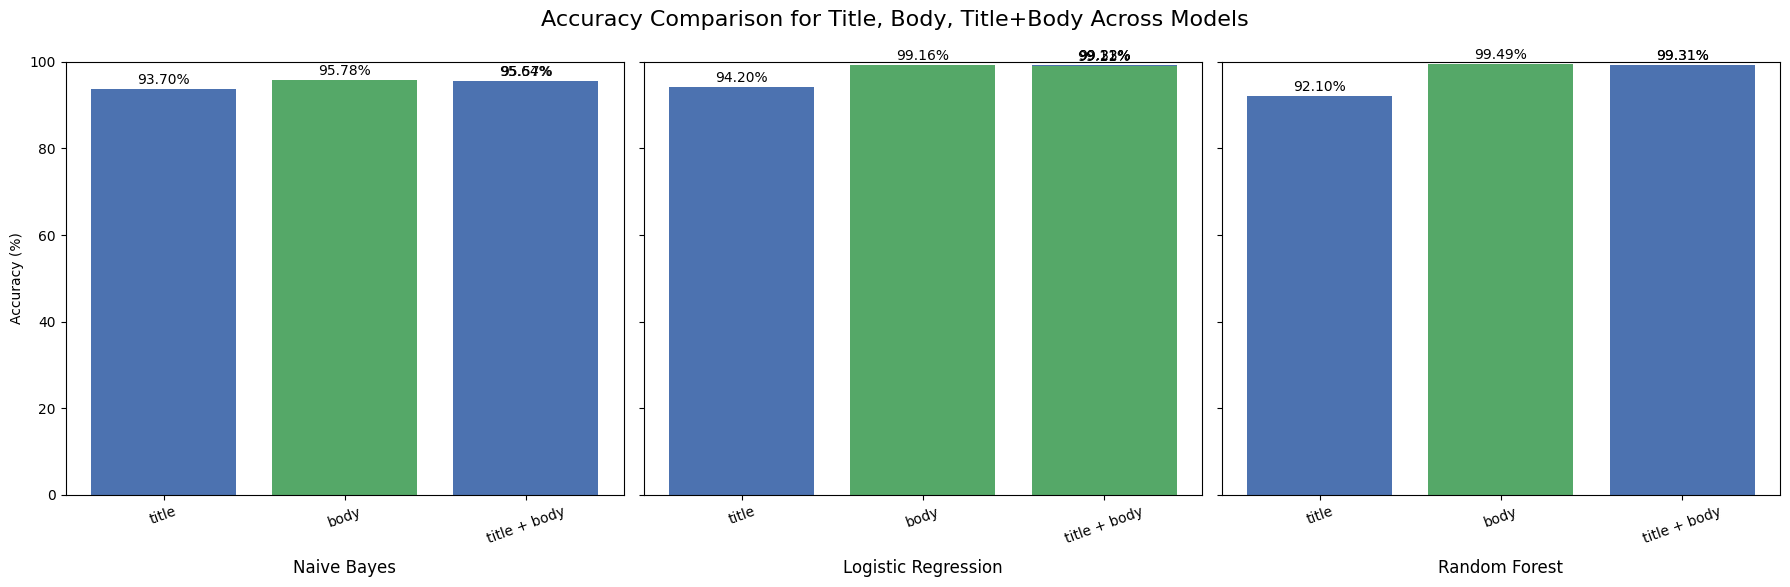

In [ ]:
import matplotlib.pyplot as plt



models = ["Naive Bayes", "Logistic Regression", "Random Forest"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, model in enumerate(models):
    subset = df_results[df_results['Model'] == model]

    bars = axes[i].bar(
        subset['Column'],
        subset['Accuracy'] * 100,   # convert to percentage
        color=['#4c72b0', '#55a868', '#c44e52'],label='title'
    )

    # Add percentage value on top of each bar
    for bar in bars:
        height = bar.get_height()
        axes[i].text(
            bar.get_x() + bar.get_width()/2,
            height + 0.5,
            f"{height:.2f}%",
            ha='center',
            va='bottom',
            fontsize=10,
            color='black',
        )

    axes[i].set_title(model,y=-0.2)
    axes[i].set_ylim(0, 100)
    axes[i].set_ylabel("Accuracy (%)" if i == 0 else "")
    axes[i].tick_params(axis='x', rotation=20)

fig.suptitle("Accuracy Comparison for Title, Body, Title+Body Across Models", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# ============================================
# 8. ERROR ANALYSIS FOR ALL THREE MODELS
# ============================================

import numpy as np
import pandas as pd

# Make sure raw split is available (from previous steps)
# X_train_raw, X_test_raw, y_train_raw, y_test_raw

models_to_analyse = {
    "Naive Bayes": global_grid_nb,          # tuned NB model
    "Logistic Regression": global_grid_lr,  # tuned LR model
    "Random Forest": global_grid_rf         # tuned RF model
}

for model_name, model in models_to_analyse.items():
    print("\n" + "="*70)
    print(f"ERROR ANALYSIS FOR: {model_name}")
    print("="*70)

    # Predictions
    preds = model.predict(X_test)

    # Create error DataFrame
    error_df = pd.DataFrame({
        "text": X_test_raw.values,
        "true_label": y_test.values, # Corrected: use y_test instead of y_test_raw
        "predicted_label": preds
    })

    # Misclassified samples
    misclassified = error_df[error_df["true_label"] != error_df["predicted_label"]]

    print(f"\nTotal misclassified samples: {len(misclassified)}")
    print("\nSample Misclassified Articles:")
    print(misclassified.head(3))

    # Breakdown
    print("\nMisclassification Breakdown:")
    print(misclassified.groupby("true_label").size())

    # Text length analysis
    error_df["text_len"] = error_df["text"].apply(lambda x: len(str(x).split()))
    correct = error_df[error_df["true_label"] == error_df["predicted_label"]]
    incorrect = error_df[error_df["true_label"] != error_df["predicted_label"]]

    print("\nAvg length (correct):", correct["text_len"].mean())
    print("Avg length (incorrect):", incorrect["text_len"].mean())

    # False positives (Fake → Real)
    print("\n=== False Positives (Pred Real, True Fake) ===")
    print(misclassified[
        (misclassified["true_label"] == 0) &
        (misclassified["predicted_label"] == 1)
    ].head(3))

    # False negatives (Real → Fake)
    print("\n=== False Negatives (Pred Fake, True Real) ===")
    print(misclassified[
        (misclassified["true_label"] == 1) &
        (misclassified["predicted_label"] == 0)
    ].head(3))

    print("\n" + "="*70)



ERROR ANALYSIS FOR: Naive Bayes

Total misclassified samples: 334

Sample Misclassified Articles:
                                                 text  true_label  \
25  u s justices skeptical of sex offender social ...           1   
36  trumpdom the curious world of trump s foreign ...           0   
48  trump talks up new york values as protesters d...           1   

    predicted_label  
25                0  
36                1  
48                0  

Misclassification Breakdown:
true_label
0    145
1    189
dtype: int64

Avg length (correct): 416.0478142076503
Avg length (incorrect): 523.7215568862275

=== False Positives (Pred Real, True Fake) ===
                                                  text  true_label  \
36   trumpdom the curious world of trump s foreign ...           0   
199  obama lies about number of troops on ground in...           0   
238  breaking news gop controlled house votes to re...           0   

     predicted_label  
36                 1  
199   